In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "/kaggle/input/statoil-iceberg-classifier-challenge"]).decode("utf8"))


# Any results you write to the current directory are saved as output.

sample_submission.csv.7z
test.json.7z
train.json.7z



This kernel is specifically is for Beginners who want's to experiment building CNN using Kearas.By using this kernel,you can expect to get good score and also learn keras. Keras is simple frameworks where we can initialize the model and keep stacking the layers we want. It makes building deep neural networks very easy.

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [3]:
#load the data.
# 데이터 불러오기.
!pip install py7zr
import py7zr

with py7zr.SevenZipFile('/kaggle/input/statoil-iceberg-classifier-challenge/train.json.7z', 'r') as archive:
    archive.extractall('/kaggle/working/')

with py7zr.SevenZipFile('/kaggle/input/statoil-iceberg-classifier-challenge/test.json.7z', 'r') as archive:
    archive.extractall('/kaggle/working/')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 73.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 8.1 MB/s eta 0:00:00


In [4]:
test = pd.read_json('/kaggle/working/data/processed/test.json')
train = pd.read_json('/kaggle/working/data/processed/train.json')

Intro about the Data.
Sentinet -1 sat is at about 680 Km above earth. Sending pulses of signals at a particular angle of incidence and then recoding it back. Basically those reflected signals are called backscatter. The data we have been given is backscatter coefficient which is the conventional form of backscatter coefficient given by:

σo(dB)=βo(dB)+10log10[sin(ip)/sin(ic)]
 
where

ip=is angle of incidence for a particular pixel
'ic ' is angle of incidence for center of the image
K =constant.
We have been given  σo
  directly in the data.

Now coming to the features of  σo
 
Basically σo varies with the surface on which the signal is scattered from. For example, for a particular angle of incidence, it varies like:

WATER........... SETTLEMENTS........ AGRICULTURE........... BARREN........
1.HH: -27.001 ................ 2.70252 ................. -12.7952 ................ -17.25790909

2.HV: -28.035 ................ -20.2665 .................. -21.4471 ................. -20.019

As you can see, the HH component varies a lot but HV doesn't. I don't have the data for scatter from ship, but being a metal object, it should vary differently as compared to ice object.

WTF is HH HV?
Ok, so this Sentinal Settalite is equivalent to RISTSAT(an Indian remote sensing Sat) and they only Transmit pings in H polarization, AND NOT IN V polarization. Those H-pings gets scattered, objects change their polarization and returns as a mix of H and V. Since Sentinel has only H-transmitter, return signals are of the form of HH and HV only. Don't ask why VV is not given(because Sentinel don't have V-ping transmitter).

Now coming to features, for the purpose of this demo code, I am extracting all two bands and taking avg of them as 3rd channel to create a 3-channel RGB equivalent.

In [5]:
#generate the training data
#create 3 bands having HH, HV and avg of both
X_band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train['band_1']])

X_band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train['band_2']])

X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

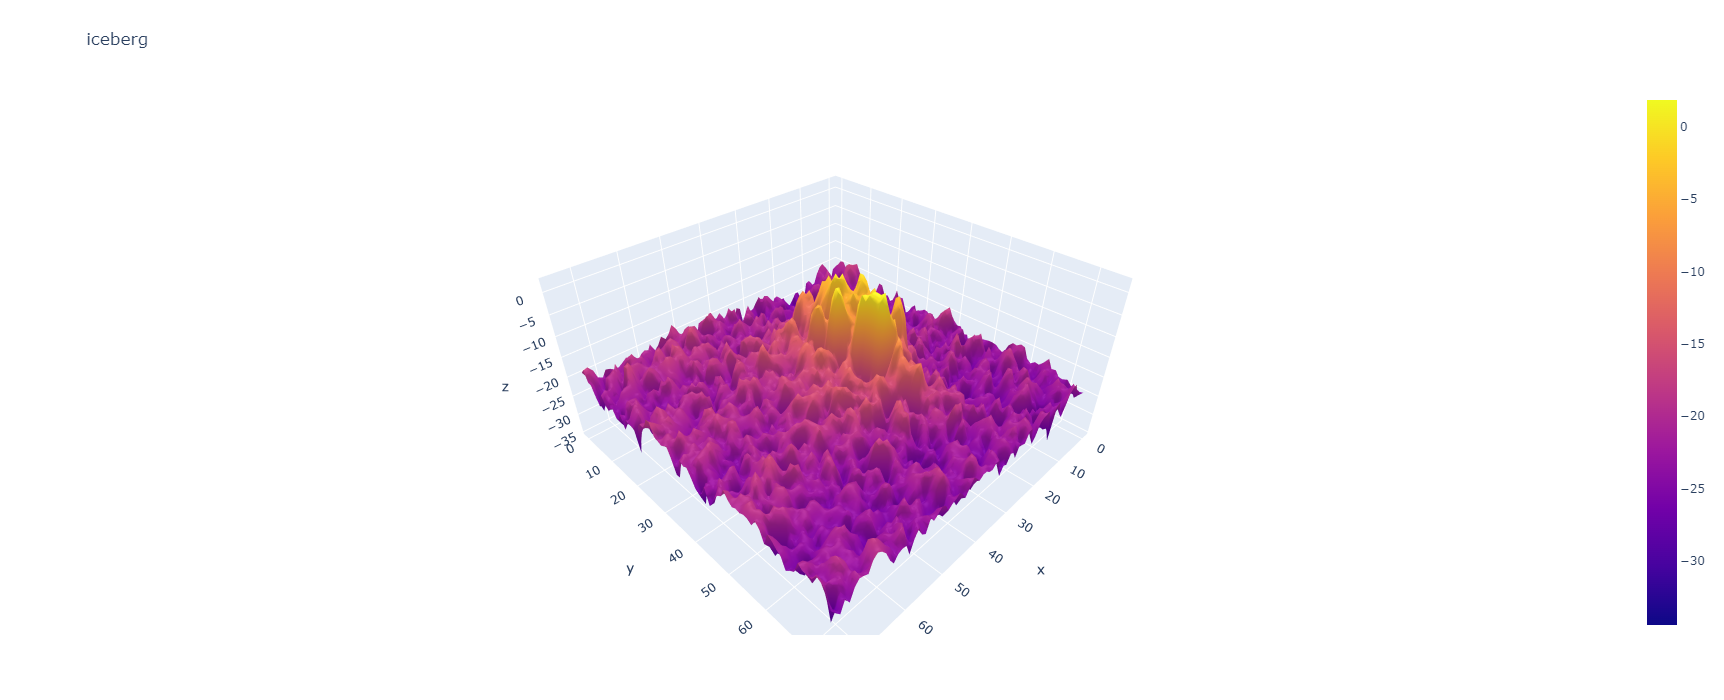

In [6]:
#take a look at a iceberg
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

def plotmy3d(c, name):
    
    data = [
        go.Surface(
            z=c)
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90)
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
plotmy3d(X_band_1[12,:,:], 'iceberg')

That's a cool looking iceverg we have. Remember, in radar data, the shape of the iceberg is going to be like a mountain as shown in here. Since this is not a actual image but scatter from radar, the shape is going to have peaks and distortions like these. The shape of the ship is going to be like a point, may be like a elongated point. From here the structural differences arise and we can exploit those differences using a CNN. it would be helpgul if we can create composite images using the backscatter form radar.

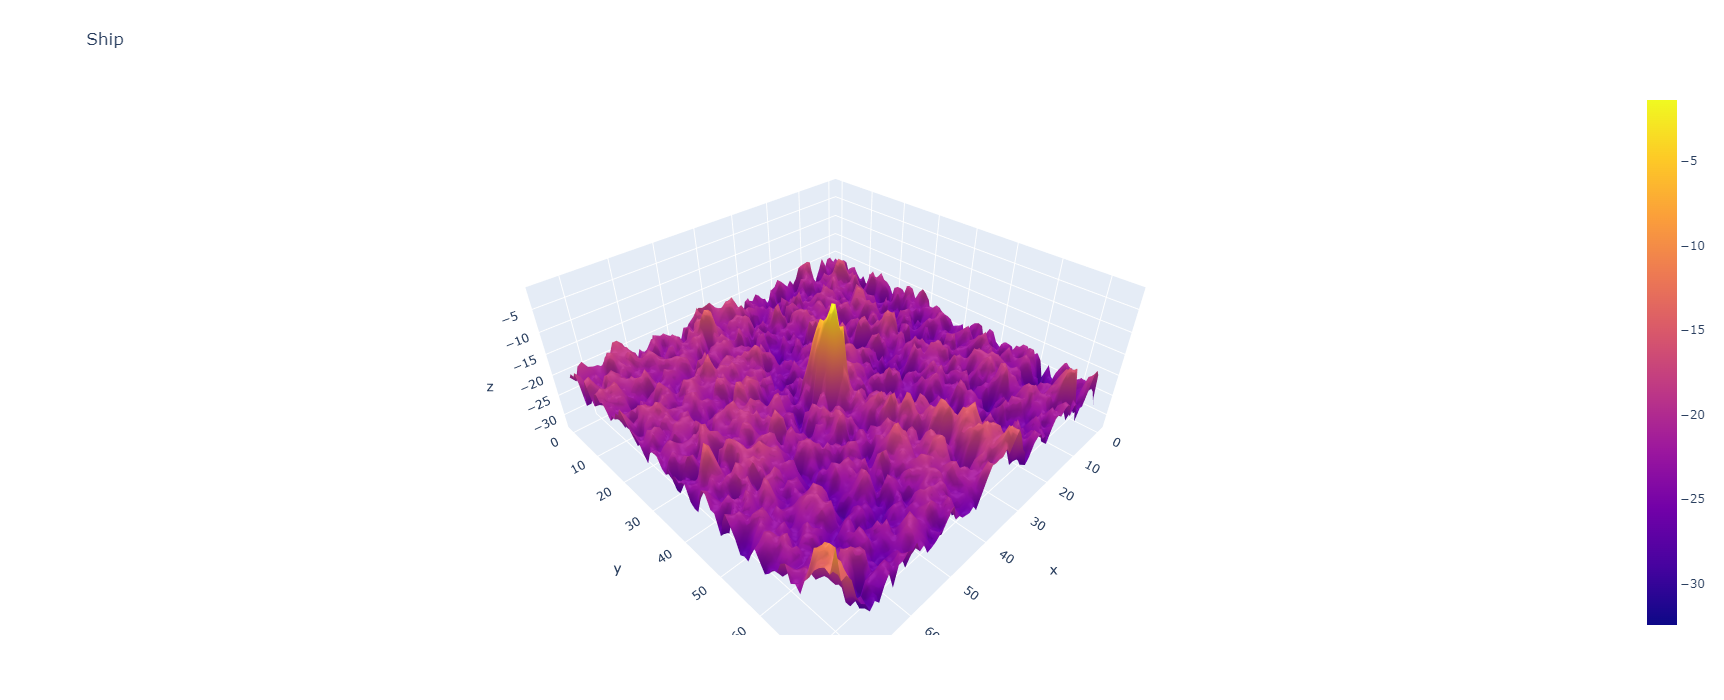

In [7]:
plotmy3d(X_band_1[14,:,:], 'Ship')

That's a ship, looks like a elongated point. We don't have nuch resolution in images to visualize the shape of the ship. However CNN is here to help. There are few papers on ship iceberg classification like this: http://elib.dlr.de/99079/2/2016_BENTES_Frost_Velotto_Tings_EUSAR_FP.pdf However their data have much better resolution so I don't feel that the CNN they used would be suitable here.

Get back to building a CNN using Keras. Much better frameworks then others, You will enjoy for sure.

In [10]:

#Import kearas.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation, BatchNormalization
from keras.layers import GlobalMaxPooling2D
from keras.layers import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [11]:
#define our model
def getModel():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 2
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

In [12]:
target_train=train['is_iceberg']
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=1, train_size=0.75)

In [14]:

#Without denoising, core features.
import os
gmodel=getModel()
gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=20,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 73, 73, 64)        1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 36, 36, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)      0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 17, 17, 128)      

In [16]:
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

13/13 [==============================] - 1s 92ms/step - loss: 0.2597 - accuracy: 0.8828
Test loss: 0.2597363293170929
Test accuracy: 0.8827930092811584


In [18]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)
predicted_test = gmodel.predict(X_test)

264/264 [==============================] - 26s 97ms/step


In [19]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('sub.csv', index=False)

Conclusion
To increase the score, I have tried Speckle filtering, Indicence angle normalization and other preprocessing and they don't seems to work. You may try and see but for me they are not giving any good results.

You can't be on top-10 using this kernel, so here is one beautiful peice of information. The test dataset contain 8000 images, We can exploit this. We can do pseudo labelling to increase the predictions. Here is the article related to that: https://towardsdatascience.com/simple-explanation-of-semi-supervised-learning-and-pseudo-labeling-c2218e8c769b

Upvote if you liked this kernel.